In [1]:
!pip install segmentation-models-pytorch

In [2]:
# !unzip custom_dataset.zip

Archive:  custom_dataset.zip
replace dataset_best/moscow_center_output.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
import torch

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [4]:
import segmentation_models_pytorch as smp

best_model = smp.DeepLabV3Plus(classes=1, activation='sigmoid')
best_model.load_state_dict(torch.load('best_deeplab.pt'))
best_model = best_model.to(device)

In [5]:
from torchvision.io import read_image

full_image = read_image('/content/dataset_best/avik_kazan_output.png')

In [6]:
original_height, original_width = full_image.shape[1:]

In [7]:
from math import ceil

In [8]:
desired_height = ceil(original_height / 256.) * 256
desired_width = ceil(original_width / 256.) * 256

In [9]:
from torchvision.transforms import Pad

pad = Pad((0, 0, desired_height - original_height, desired_width - original_width))
full_image = pad(full_image)

In [33]:
crops = []
indexes = []

for y in range(desired_height // 256 * 2 - 1):
    for x in range(desired_width // 256 * 2 - 1):
        crops.append(full_image[:, y * 128: y * 128 + 256, x * 128: x * 128 + 256].unsqueeze(0))
        indexes.append((y * 128, y * 128 + 256, x * 128, x * 128 + 256))

crops = torch.cat(crops, dim=0).float()

In [11]:
from torch.utils.data import DataLoader

crops_loader = DataLoader(crops, batch_size=1, shuffle=False)

In [12]:
results = []

best_model.eval()

with torch.no_grad():
    for batch in crops_loader:
        x = batch.to(device)
        results.append(best_model(x).cpu())

In [35]:
import numpy as np

result_mask = np.zeros((desired_height, desired_width), dtype=bool)

In [37]:
for index, result in zip(indexes, results):
    top, bottom, left, right = index
    result_mask[top: bottom, left: right] |= result.squeeze().numpy() > 0.5

In [43]:
result_mask = result_mask[:original_height, :original_width].copy()

In [44]:
import matplotlib.pyplot as plt

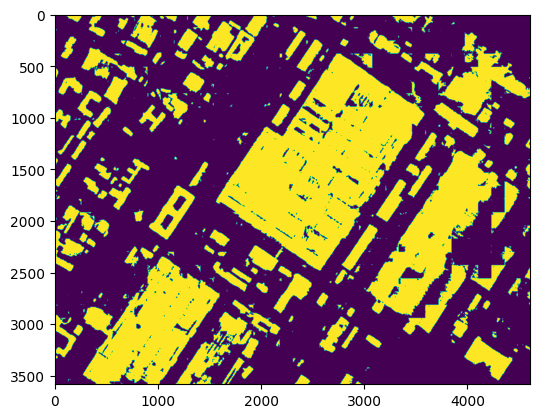

In [45]:
figure, axes = plt.subplots()

axes.imshow(result_mask)

plt.show()

In [49]:
import cv2 as cv

mask_target = cv.imread('/content/dataset_best/avik_kazan_mask.png', cv.IMREAD_GRAYSCALE) // 255

In [52]:
uint_result_mask = result_mask.astype(np.uint8)

In [54]:
from sklearn.metrics import f1_score

print(f1_score(mask_target.flatten(), uint_result_mask.flatten()))

0.8134992278982222


In [57]:
from math import ceil
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torchvision.transforms import Pad
import segmentation_models_pytorch as smp


def get_mask(image_path: str):
    full_image = read_image(image_path)

    original_height, original_width = full_image.shape[1:]
    desired_height = ceil(original_height / 256.) * 256
    desired_width = ceil(original_width / 256.) * 256

    pad = Pad((0, 0, desired_height - original_height, desired_width - original_width))
    full_image = pad(full_image)

    crops = []
    indices = []

    for y in range(desired_height // 256 * 2 - 1):
        for x in range(desired_width // 256 * 2 - 1):
            crops.append(full_image[:, y * 128: y * 128 + 256, x * 128: x * 128 + 256].unsqueeze(0))
            indices.append((y * 128, y * 128 + 256, x * 128, x * 128 + 256))

    crops = torch.cat(crops, dim=0).float()
    crops_loader = DataLoader(crops, batch_size=1, shuffle=False)

    results = []

    best_model.eval()

    with torch.no_grad():
        for batch in crops_loader:
            x = batch.to(device)
            results.append(best_model(x).cpu())

    result_mask = np.zeros((desired_height, desired_width), dtype=bool)

    for index, result in zip(indices, results):
        top, bottom, left, right = index
        result_mask[top: bottom, left: right] |= result.squeeze().numpy() > 0.5

    result_mask = result_mask[:original_height, :original_width].copy()

    return result_mask.astype(np.uint8)

In [65]:
print(f1_score((cv.imread('/content/dataset_best/ylyanovsk_dacha_mask.png', cv.IMREAD_GRAYSCALE) // 255).flatten(), get_mask('/content/dataset_best/ylyanovsk_dacha_output.png').flatten()))

0.6125684885841124


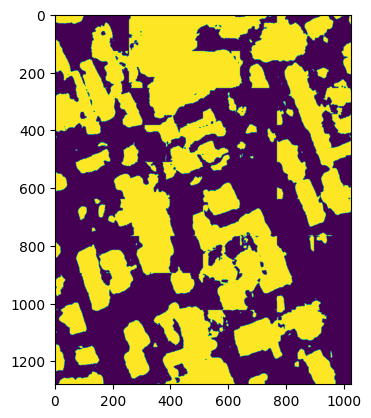

In [59]:
moscow_center_mask = get_mask('/content/dataset_best/moscow_center_output.png')

figure, axes = plt.subplots()

axes.imshow(moscow_center_mask)

plt.show()

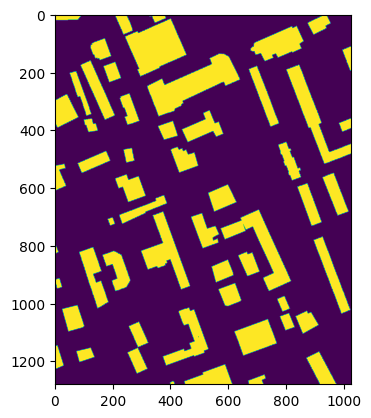

In [60]:
figure, axes = plt.subplots()

axes.imshow(cv.imread('/content/dataset_best/moscow_center_mask.png', cv.IMREAD_GRAYSCALE) // 255)

plt.show()

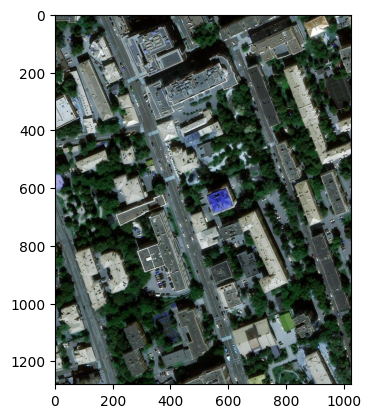

In [61]:
figure, axes = plt.subplots()

axes.imshow(cv.imread('/content/dataset_best/moscow_center_output.png'))

plt.show()